In [5]:
# --------------------------------------------------------
# SiamMask
# Licensed under The MIT License
# Written by Qiang Wang (wangqiang2015 at ia.ac.cn)
# --------------------------------------------------------
import argparse
import logging
import os
import cv2
import shutil
import time
import json
import math
import torch
from torch.utils.data import DataLoader

from utils.log_helper import init_log, print_speed, add_file_handler, Dummy
from utils.load_helper import load_pretrain, restore_from
from utils.average_meter_helper import AverageMeter

from datasets.siam_mask_dataset import DataSets

from utils.lr_helper import build_lr_scheduler
from tensorboardX import SummaryWriter

from utils.config_helper import load_config
from torch.utils.collect_env import get_pretty_env_info

torch.backends.cudnn.benchmark = True

parser = argparse.ArgumentParser(description='PyTorch Tracking SiamMask Training')

parser.add_argument('-j', '--workers', default=1, type=int, metavar='N',
                    help='number of data loading workers (default: 16)')
parser.add_argument('--epochs', default=20, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch', default=64, type=int,
                    metavar='N', help='mini-batch size (default: 64)')
parser.add_argument('--lr', '--learning-rate', default=0.001, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--clip', default=10.0, type=float,
                    help='gradient clip value')
parser.add_argument('--print-freq', '-p', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('--pretrained', dest='pretrained', default='',
                    help='use pre-trained model')
parser.add_argument('--config', dest='config', required=True,
                    help='hyperparameter of SiamMask in json format')
parser.add_argument('--arch', dest='arch', default='', choices=['Custom',],
                    help='architecture of pretrained model')
parser.add_argument('-l', '--log', default="log.txt", type=str,
                    help='log file')
parser.add_argument('-s', '--save_dir', default='snapshot', type=str,
                    help='save dir')
parser.add_argument('--log-dir', default='board', help='TensorBoard log dir')


best_acc = 0.


def collect_env_info():
    env_str = get_pretty_env_info()
    env_str += "\n        OpenCV ({})".format(cv2.__version__)
    return env_str


def build_data_loader(cfg):
    logger = logging.getLogger('global')

    logger.info("build train dataset")  # train_dataset
    train_set = DataSets(cfg['train_datasets'], cfg['anchors'], args.epochs)
    train_set.shuffle()

    logger.info("build val dataset")  # val_dataset
    if not 'val_datasets' in cfg.keys():
        cfg['val_datasets'] = cfg['train_datasets']
    val_set = DataSets(cfg['val_datasets'], cfg['anchors'])
    val_set.shuffle()

    train_loader = DataLoader(train_set, batch_size=args.batch, num_workers=args.workers,
                              pin_memory=True, sampler=None)
    val_loader = DataLoader(val_set, batch_size=args.batch, num_workers=args.workers,
                            pin_memory=True, sampler=None)

    logger.info('build dataset done')
    return train_loader, val_loader


def build_opt_lr(model, cfg, args, epoch):
    backbone_feature = model.features.param_groups(cfg['lr']['start_lr'], cfg['lr']['feature_lr_mult'])
    if len(backbone_feature) == 0:
        trainable_params = model.rpn_model.param_groups(cfg['lr']['start_lr'], cfg['lr']['rpn_lr_mult'], 'mask')
    else:
        trainable_params = backbone_feature + \
                           model.rpn_model.param_groups(cfg['lr']['start_lr'], cfg['lr']['rpn_lr_mult']) + \
                           model.mask_model.param_groups(cfg['lr']['start_lr'], cfg['lr']['mask_lr_mult'])

    optimizer = torch.optim.SGD(trainable_params, args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    lr_scheduler = build_lr_scheduler(optimizer, cfg['lr'], epochs=args.epochs)

    lr_scheduler.step(epoch)

    return optimizer, lr_scheduler


def main():
    global args, best_acc, tb_writer, logger
    args = parser.parse_args()

    init_log('global', logging.INFO)

    if args.log != "":
        add_file_handler('global', args.log, logging.INFO)

    
    print("Init logger")

    logger = logging.getLogger('global')

    print(44)
    #logger.info("\n" + collect_env_info())
    print(99)
    logger.info(args)

    cfg = load_config(args)
    logger.info("config \n{}".format(json.dumps(cfg, indent=4)))

    print(2)

    if args.log_dir:
        tb_writer = SummaryWriter(args.log_dir)
    else:
        tb_writer = Dummy()

    # build dataset
    train_loader, val_loader = build_data_loader(cfg)

    print(3)

    if args.arch == 'Custom':
        from custom import Custom
        model = Custom(pretrain=True, anchors=cfg['anchors'])
    else:
        exit()
    logger.info(model)

    print(4)

    if args.pretrained:
        model = load_pretrain(model, args.pretrained)

    model = model.cuda()
    dist_model = torch.nn.DataParallel(model, list(range(torch.cuda.device_count()))).cuda()

    if args.resume and args.start_epoch != 0:
        model.features.unfix((args.start_epoch - 1) / args.epochs)

    optimizer, lr_scheduler = build_opt_lr(model, cfg, args, args.start_epoch)
    # optionally resume from a checkpoint
    if args.resume:
        assert os.path.isfile(args.resume), '{} is not a valid file'.format(args.resume)
        model, optimizer, args.start_epoch, best_acc, arch = restore_from(model, optimizer, args.resume)
        dist_model = torch.nn.DataParallel(model, list(range(torch.cuda.device_count()))).cuda()

    logger.info(lr_scheduler)

    logger.info('model prepare done')

    train(train_loader, dist_model, optimizer, lr_scheduler, args.start_epoch, cfg)


def train(train_loader, model, optimizer, lr_scheduler, epoch, cfg):
    global tb_index, best_acc, cur_lr, logger
    cur_lr = lr_scheduler.get_cur_lr()
    logger = logging.getLogger('global')
    avg = AverageMeter()
    model.train()
    model = model.cuda()
    end = time.time()

    def is_valid_number(x):
        return not(math.isnan(x) or math.isinf(x) or x > 1e4)

    num_per_epoch = len(train_loader.dataset) // args.epochs // args.batch
    start_epoch = epoch
    epoch = epoch
    for iter, input in enumerate(train_loader):

        if epoch != iter // num_per_epoch + start_epoch:  # next epoch
            epoch = iter // num_per_epoch + start_epoch

            if not os.path.exists(args.save_dir):  # makedir/save model
                os.makedirs(args.save_dir)

            save_checkpoint({
                    'epoch': epoch,
                    'arch': args.arch,
                    'state_dict': model.module.state_dict(),
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict(),
                    'anchor_cfg': cfg['anchors']
                }, False,
                os.path.join(args.save_dir, 'checkpoint_e%d.pth' % (epoch)),
                os.path.join(args.save_dir, 'best.pth'))

            if epoch == args.epochs:
                return

            if model.module.features.unfix(epoch/args.epochs):
                logger.info('unfix part model.')
                optimizer, lr_scheduler = build_opt_lr(model.module, cfg, args, epoch)

            lr_scheduler.step(epoch)
            cur_lr = lr_scheduler.get_cur_lr()

            logger.info('epoch:{}'.format(epoch))

        tb_index = iter
        if iter % num_per_epoch == 0 and iter != 0:
            for idx, pg in enumerate(optimizer.param_groups):
                logger.info("epoch {} lr {}".format(epoch, pg['lr']))
                tb_writer.add_scalar('lr/group%d' % (idx+1), pg['lr'], tb_index)

        data_time = time.time() - end
        avg.update(data_time=data_time)
        x = {
            'cfg': cfg,
            'template': torch.autograd.Variable(input[0]).cuda(),
            'search': torch.autograd.Variable(input[1]).cuda(),
            'label_cls': torch.autograd.Variable(input[2]).cuda(),
            'label_loc': torch.autograd.Variable(input[3]).cuda(),
            'label_loc_weight': torch.autograd.Variable(input[4]).cuda(),
            'label_mask': torch.autograd.Variable(input[6]).cuda(),
            'label_mask_weight': torch.autograd.Variable(input[7]).cuda(),
        }

        outputs = model(x)

        rpn_cls_loss, rpn_loc_loss, rpn_mask_loss = torch.mean(outputs['losses'][0]), torch.mean(outputs['losses'][1]), torch.mean(outputs['losses'][2])
        mask_iou_mean, mask_iou_at_5, mask_iou_at_7 = torch.mean(outputs['accuracy'][0]), torch.mean(outputs['accuracy'][1]), torch.mean(outputs['accuracy'][2])

        cls_weight, reg_weight, mask_weight = cfg['loss']['weight']

        loss = rpn_cls_loss * cls_weight + rpn_loc_loss * reg_weight + rpn_mask_loss * mask_weight

        optimizer.zero_grad()
        loss.backward()

        if cfg['clip']['split']:
            torch.nn.utils.clip_grad_norm_(model.module.features.parameters(), cfg['clip']['feature'])
            torch.nn.utils.clip_grad_norm_(model.module.rpn_model.parameters(), cfg['clip']['rpn'])
            torch.nn.utils.clip_grad_norm_(model.module.mask_model.parameters(), cfg['clip']['mask'])
        else:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)  # gradient clip

        if is_valid_number(loss.item()):
            optimizer.step()

        siammask_loss = loss.item()

        batch_time = time.time() - end

        avg.update(batch_time=batch_time, rpn_cls_loss=rpn_cls_loss, rpn_loc_loss=rpn_loc_loss,
                   rpn_mask_loss=rpn_mask_loss, siammask_loss=siammask_loss,
                   mask_iou_mean=mask_iou_mean, mask_iou_at_5=mask_iou_at_5, mask_iou_at_7=mask_iou_at_7)

        tb_writer.add_scalar('loss/cls', rpn_cls_loss, tb_index)
        tb_writer.add_scalar('loss/loc', rpn_loc_loss, tb_index)
        tb_writer.add_scalar('loss/mask', rpn_mask_loss, tb_index)
        tb_writer.add_scalar('mask/mIoU', mask_iou_mean, tb_index)
        tb_writer.add_scalar('mask/AP@.5', mask_iou_at_5, tb_index)
        tb_writer.add_scalar('mask/AP@.7', mask_iou_at_7, tb_index)
        end = time.time()

        if (iter + 1) % args.print_freq == 0:
            logger.info('Epoch: [{0}][{1}/{2}] lr: {lr:.6f}\t{batch_time:s}\t{data_time:s}'
                        '\t{rpn_cls_loss:s}\t{rpn_loc_loss:s}\t{rpn_mask_loss:s}\t{siammask_loss:s}'
                        '\t{mask_iou_mean:s}\t{mask_iou_at_5:s}\t{mask_iou_at_7:s}'.format(
                        epoch+1, (iter + 1) % num_per_epoch, num_per_epoch, lr=cur_lr, batch_time=avg.batch_time,
                        data_time=avg.data_time, rpn_cls_loss=avg.rpn_cls_loss, rpn_loc_loss=avg.rpn_loc_loss,
                        rpn_mask_loss=avg.rpn_mask_loss, siammask_loss=avg.siammask_loss, mask_iou_mean=avg.mask_iou_mean,
                        mask_iou_at_5=avg.mask_iou_at_5,mask_iou_at_7=avg.mask_iou_at_7))
            print_speed(iter + 1, avg.batch_time.avg, args.epochs * num_per_epoch)


def save_checkpoint(state, is_best, filename='checkpoint.pth', best_file='model_best.pth'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, best_file)

In [6]:
global args, best_acc, tb_writer, logger

In [7]:
args = parser.parse_args(["--config", "/projectnb/ece601/cliao25/SiamMask/experiments/siammask_base/config.json","-b","32","-j","6"])

In [8]:
args

Namespace(arch='', batch=32, clip=10.0, config='/projectnb/ece601/cliao25/SiamMask/experiments/siammask_base/config.json', epochs=20, log='log.txt', log_dir='board', lr=0.001, momentum=0.9, pretrained='', print_freq=10, resume='', save_dir='snapshot', start_epoch=0, weight_decay=0.0001, workers=6)

In [9]:
cfg = load_config(args)

In [143]:
train_loader, val_loader = build_data_loader(cfg)

[2021-04-18 21:49:13,602-rk0-<ipython-input-1-648063a4f664># 78] build train dataset
[2021-04-18 21:49:13,603-rk0-siam_mask_dataset.py# 36] loading /scratch/cliao25/data/ytb_vos/train.json
[2021-04-18 21:49:13,830-rk0-siam_mask_dataset.py# 74] /scratch/cliao25/data/ytb_vos/train.json loaded.
[2021-04-18 21:49:13,938-rk0-siam_mask_dataset.py#134] SubDataSet ytb_vos start-index 0 select [200000/3000] path {}.{}.{}.jpg
[2021-04-18 21:49:13,938-rk0-siam_mask_dataset.py# 36] loading /scratch/cliao25/data/vid/train.json
[2021-04-18 21:49:17,905-rk0-siam_mask_dataset.py# 74] /scratch/cliao25/data/vid/train.json loaded.
[2021-04-18 21:49:18,004-rk0-siam_mask_dataset.py#134] SubDataSet vid start-index 3000 select [200000/3862] path {}.{}.{}.jpg
[2021-04-18 21:49:18,005-rk0-siam_mask_dataset.py# 36] loading /scratch/cliao25/data/coco/train2017.json
[2021-04-18 21:49:22,514-rk0-siam_mask_dataset.py#118] Error, coco train2017/000000512390 12 [366.3, 120.6, 372.24, 120.6]
[2021-04-18 21:49:23,793-r

In [10]:
from custom import Custom

In [12]:
model = Custom(pretrain=False, anchors=cfg['anchors'])
#path = "/usr4/alg504/cliao25/siammask/experiments/siammask_base/snapshot/checkpoint_e{}.pth"
epoch=1
filepath = path.format(epoch)
assert os.path.isfile(filepath)
    
model = model.cuda()

optimizer, lr_scheduler = build_opt_lr(model, cfg, args, epoch)
filepath = path.format(epoch)
assert os.path.isfile(filepath)

#model, _, _, _, _ = restore_from(model, optimizer, filepath)

model = torch.nn.DataParallel(model, list(range(torch.cuda.device_count()))).cuda()

model.train()
device = torch.device('cuda')
model = model.to(device)

[2021-04-18 22:35:44,996-rk0-features.py# 66] Current training 0 layers:
	
[2021-04-18 22:35:44,998-rk0-features.py# 66] Current training 1 layers:
	


In [13]:
save_checkpoint({
                    'epoch': 40,
                    'arch': args.arch,
                    'state_dict': model.module.state_dict(),
                    'best_acc': 0,
                    'optimizer': optimizer.state_dict(),
                    'anchor_cfg': cfg['anchors']
                }, False,
                'checkpoint_e%d.pth' % (40),
                'best.pth')

In [196]:
with torch.no_grad():
    
    for iter, input in enumerate(val_loader):
        x = {
                          'cfg': cfg,
                          'template': torch.autograd.Variable(input[0]).cuda(),
                          'search': torch.autograd.Variable(input[1]).cuda(),
                          'label_cls': torch.autograd.Variable(input[2]).cuda(),
                          'label_loc': torch.autograd.Variable(input[3]).cuda(),
                          'label_loc_weight': torch.autograd.Variable(input[4]).cuda(),
                          'label_mask': torch.autograd.Variable(input[6]).cuda(),
                          'label_mask_weight': torch.autograd.Variable(input[7]).cuda(),
                      }
        outputs = model(x)
        rpn_cls_loss, rpn_mask_loss = torch.mean(outputs['losses'][0]), torch.mean(outputs['losses'][1])
        mask_iou_mean, mask_iou_at_5, mask_iou_at_7 = torch.mean(outputs['accuracy'][0]), torch.mean(outputs['accuracy'][1]), torch.mean(outputs['accuracy'][2])

        cls_weight, reg_weight, mask_weight = cfg['loss']['weight']
        print(rpn_cls_loss)
        print(rpn_mask_loss)
        print(mask_iou_mean)
        print(mask_iou_at_5)
        print(mask_iou_at_7)

tensor(2.8722, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(2.6042, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(2.6948, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(2.8367, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(2.7747, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(2.6168, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(2.6745, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='c

[2021-04-18 22:13:16,362-rk0-resnet.py<forward>#231] p3 torch.Size([6, 1024, 15, 15])
[2021-04-18 22:13:16,369-rk0-resnet.py<forward>#231] p3 torch.Size([5, 1024, 15, 15])
[2021-04-18 22:13:16,722-rk0-resnet.py<forward>#231] p3 torch.Size([6, 1024, 31, 31])
[2021-04-18 22:13:16,722-rk0-resnet.py<forward>#231] p3 torch.Size([5, 1024, 31, 31])


tensor(2.7087, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


In [199]:
len(val_loader.dataset)/val_loader.batch_size

17.34375

In [175]:
rpn_cls_loss, rpn_mask_loss = torch.mean(outputs['losses'][0]), torch.mean(outputs['losses'][1])
mask_iou_mean, mask_iou_at_5, mask_iou_at_7 = torch.mean(outputs['accuracy'][0]), torch.mean(outputs['accuracy'][1]), torch.mean(outputs['accuracy'][2])

cls_weight, reg_weight, mask_weight = cfg['loss']['weight']

In [176]:
print(rpn_cls_loss)
print(rpn_mask_loss)
print(mask_iou_mean)
print(mask_iou_at_5)
print(mask_iou_at_7)

tensor(0.1587, device='cuda:0')
tensor(0.1527, device='cuda:0')
tensor(0.6107, device='cuda:0')
tensor(0.8351, device='cuda:0')
tensor(0.4522, device='cuda:0')


In [177]:
float(mask_iou_at_7)

0.4521576166152954

In [178]:
outputs['accuracy'][0]

tensor([0.5901, 0.6312], device='cuda:0')

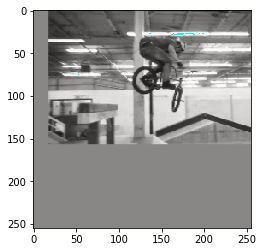

In [179]:
import numpy as np
import matplotlib.pyplot as plt
n = np.array(input[1][8,:,:,:])
n = n.astype(np.uint8)
n = np.einsum('ijk -> jki', n)
plt.imshow(n)

(255, 255)


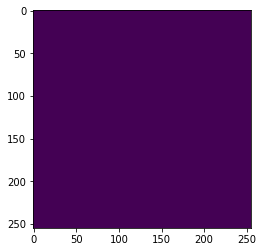

In [180]:
import numpy as np
import matplotlib.pyplot as plt
n = np.array(input[6][8,:,:,:].squeeze(0))
print(n.shape)
n = n.astype(np.uint8)
plt.imshow(n)

In [181]:
outputs['predict'][2].shape

torch.Size([32, 3969, 25, 25])

In [182]:
from torch import nn
import torch.nn.functional as F

g_sz=127
o_sz=63
weight = input[7]
weight = weight.view(-1).cuda()
mask = input[6].cuda()
pos = torch.autograd.Variable(weight.data.eq(1).nonzero().squeeze())
if pos.nelement() == 0: print("error")
p_m = outputs['predict'][2]
p_m = p_m.permute(0, 2, 3, 1).contiguous().view(-1, 1, o_sz, o_sz)
p_m = torch.index_select(p_m, 0, pos)
p_m = nn.UpsamplingBilinear2d(size=[g_sz, g_sz])(p_m)
p_m = p_m.view(-1, g_sz * g_sz)

def iou_measure(pred, label):
    pred = pred.ge(0)
    mask_sum = pred.eq(1).add(label.eq(1))
    intxn = torch.sum(mask_sum == 2, dim=1).float()
    union = torch.sum(mask_sum > 0, dim=1).float()
    iou = intxn/union
    return torch.mean(iou), (torch.sum(iou > 0.5).float()/iou.shape[0]), (torch.sum(iou > 0.7).float()/iou.shape[0])
mask_uf = F.unfold(mask, (g_sz, g_sz), padding=32, stride=8)
mask_uf = torch.transpose(mask_uf, 1, 2).contiguous().view(-1, g_sz * g_sz)
    
mask_uf = torch.index_select(mask_uf, 0, pos)
loss = F.soft_margin_loss(p_m, mask_uf)
iou_m, iou_5, iou_7 = iou_measure(p_m, mask_uf)

print(iou_m)
print(iou_5)
print(iou_7)

tensor(0.6131, device='cuda:0')
tensor(0.8387, device='cuda:0')
tensor(0.4624, device='cuda:0')


In [194]:
print(mask.shape)
mask_uf = F.unfold(mask, (g_sz, g_sz), padding=32, stride=8)
print(mask_uf.shape)
print(outputs['predict'][2].shape)
print(p_m.shape)

torch.Size([32, 1, 255, 255])
torch.Size([32, 16129, 625])
torch.Size([32, 3969, 25, 25])
torch.Size([93, 16129])


In [142]:
model.module.select_mask_logistic_loss(outputs['predict'][2], input[6], input[7])

AttributeError: 'Custom' object has no attribute 'select_mask_logistic_loss'